In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load data

In [4]:
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
suppl_cvs = np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
cv_trajs = [*cv_trajs, *suppl_cvs]

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
remove = [
    1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
]

In [7]:
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_trajs = [
    *sb_trajs,
    *np.load("../../data/raw_feat/feat2_suppl_00.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_01.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_02.npy", allow_pickle=True),
    *np.load("../../data/raw_feat/feat2_suppl_03.npy", allow_pickle=True),
]

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3432000, 2) (3432000, 60)


# Load feature 5 for supplemental trajectories

In [9]:
feat5 = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
pair_indices5 = np.loadtxt(
    "../../amber-gpu/pyemma-civsd-feat5-msmb-combined/AtomIndices.txt", dtype=np.int32
)
feat5.add_residue_mindist(
    residue_pairs=pair_indices5, scheme="closest-heavy", threshold=0.45, periodic=False
)
print(len(feat5.describe()))

1924


In [9]:
suppl_xtcs = []
for i in range(83, 164):
    d = str(i).zfill(3)
    suppl_xtcs.append(f"../../suppl-runs/{d}/civsd_pro.xtc")
for j in range(2, 5):
    for i in range(83, 104):
        d = str(i).zfill(3)
        suppl_xtcs.append(f"../../suppl-runs/{d}/civsd_pro_{j}.xtc")
print(len(suppl_xtcs))

144


In [16]:
suppl_feat5 = pyemma.coordinates.load(suppl_xtcs, features=feat5, chunksize=24)

In [18]:
np.savez_compressed("../../data/raw_feat/feat5_suppl_00", suppl_feat5)

In [10]:
with np.load("../../data/raw_feat/feat5_suppl_00.npz") as f:
    suppl_feat5 = f["arr_0"]

In [11]:
print(len(suppl_feat5), suppl_feat5[0].shape)

144 (3000, 1924)


In [12]:
type(suppl_feat5[0][0, 0])

numpy.float32

## IVAC transformation

In [15]:
# load old feature 5 data
with np.load("../../data/raw_feat/feat5_raw.npz", allow_pickle=True) as f:
    feat5_trajs = f["arr_0"]
feat5_trajs = list(feat5_trajs)
for idx in sorted(remove, reverse=True):
    del feat5_trajs[idx]
feat5_trajs = [*feat5_trajs[1000:], *suppl_feat5]
print(len(feat5_trajs), feat5_trajs[0].shape)

381 (10000, 1924)


In [16]:
print(feat5_trajs[-1].shape)

(3000, 1924)


In [21]:
livac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
livac.fit(feat5_trajs)
ivac_trajs = livac.transform(feat5_trajs)
ivac_arr = np.concatenate(ivac_trajs)
print(ivac_arr.shape)

(3432000, 10)


In [112]:
livac = ivac.LinearIVAC(minlag=1, maxlag=10000, nevecs=10, addones=False, adjust=True)
livac.fit(feat5_trajs)
ivac_trajs = livac.transform(feat5_trajs)
ivac_arr = np.concatenate(ivac_trajs)
print(ivac_arr.shape)

(3432000, 10)


In [122]:
ivac_arr[-1]

array([ 7.25237625e-03, -2.71511862e-01, -7.34128580e+00,  3.57968913e-01,
        3.47625915e-01, -3.32209285e-01,  4.01635972e-02,  4.78716763e-01,
       -9.06538185e-02,  1.34997118e-01])

In [126]:
np.save("../../data/raw_feat/feat5_ivac_suppl.npy", ivac_trajs)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [13]:
ivac_trajs = np.load("../../data/raw_feat/feat5_ivac_suppl.npy", allow_pickle=True)

In [14]:
print(len(ivac_trajs), ivac_trajs[0].shape)

381 (10000, 10)


In [117]:
livac.evals.shape

(1924,)

In [15]:
%matplotlib inline

Text(0, 0.5, 'Implied timescales ($\\mu$s)')

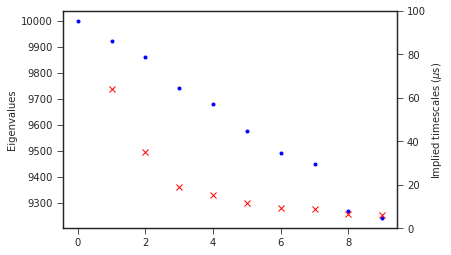

In [133]:
# do some plotting
plt.plot(livac.evals[:10], ".", color="blue")
plt.ylabel("Eigenvalues")
plt.twinx()
plt.plot(livac.its[:10] * 0.0001, "x", color="red")
plt.ylim([0, 100])
plt.ylabel("Implied timescales ($\mu$s)")

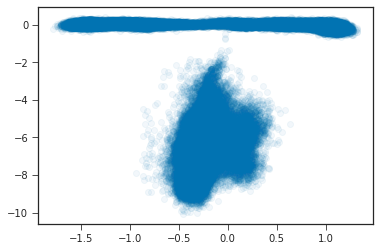

In [17]:
ivac_arr = np.concatenate(ivac_trajs)
end = len(ivac_arr)
plt.scatter(ivac_arr[:end:10, 1], ivac_arr[:end:10, 2], alpha=0.05)

[None]

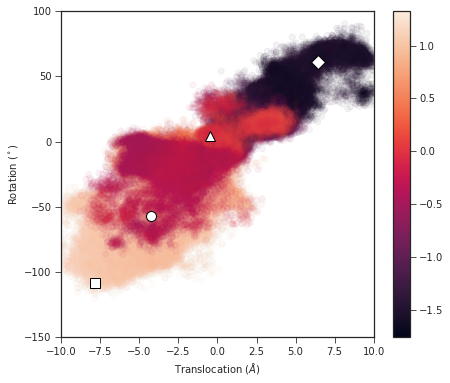

In [18]:
s = 20
f, ax = plt.subplots(figsize=(7, 6))
h = ax.scatter(
    cv_arr[::s, 0], cv_arr[::s, 1], c=ivac_arr[::s, 1], cmap="rocket", alpha=0.05
)
plotting.format_cvs(ax, centroids=True)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)

[None]

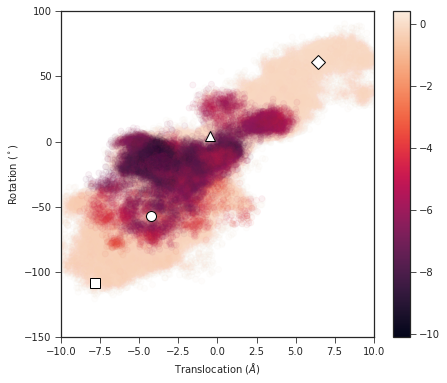

In [19]:
s = 20
f, ax = plt.subplots(figsize=(7, 6))
h = ax.scatter(
    cv_arr[::s, 0], cv_arr[::s, 1], c=ivac_arr[::s, 2], cmap="rocket", alpha=0.05
)
plotting.format_cvs(ax, centroids=True)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)

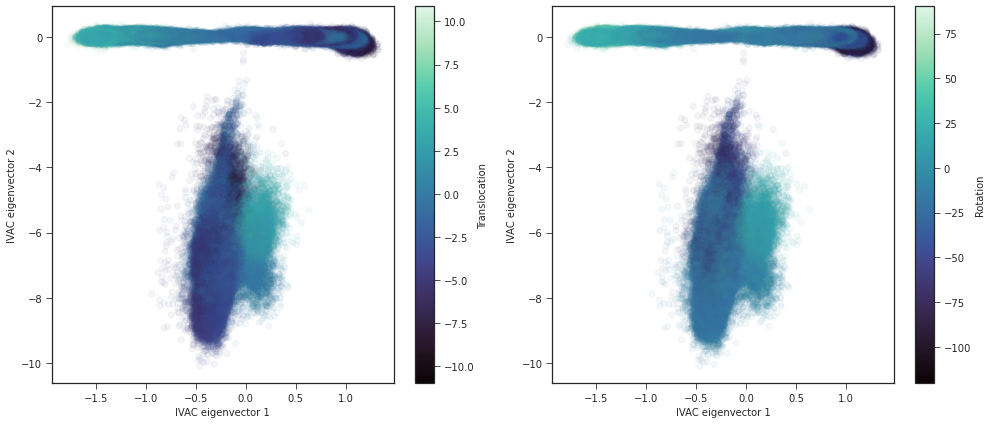

In [23]:
# project onto IVAC eigenvectors
f, axes = plt.subplots(1, 2, figsize=(14, 6))
labels = ("Translocation", "Rotation")
start = 0
end = len(ivac_arr)
for i, ax in enumerate(axes):
    h0 = ax.scatter(
        ivac_arr[start:end:10, 1],
        ivac_arr[start:end:10, 2],
        c=cv_arr[start::10, i],
        alpha=0.05,
        cmap="mako",
    )
    cbar = plt.colorbar(h0, ax=ax, label=labels[i])
    cbar.solids.set(alpha=1)
    ax.set(xlabel="IVAC eigenvector 1", ylabel="IVAC eigenvector 2")

f.tight_layout()

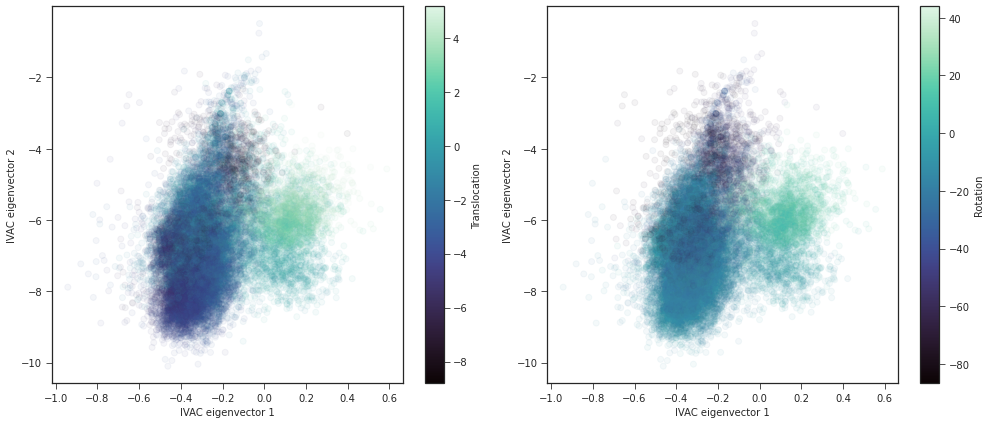

In [26]:
# project onto IVAC eigenvectors
f, axes = plt.subplots(1, 2, figsize=(14, 6))
labels = ("Translocation", "Rotation")
start = 3000000
end = len(ivac_arr)
for i, ax in enumerate(axes):
    h0 = ax.scatter(
        ivac_arr[start:end:s, 1],
        ivac_arr[start:end:s, 2],
        c=cv_arr[start:end:s, i],
        alpha=0.05,
        cmap="mako",
    )
    cbar = plt.colorbar(h0, ax=ax, label=labels[i])
    cbar.solids.set(alpha=1)
    ax.set(xlabel="IVAC eigenvector 1", ylabel="IVAC eigenvector 2")

f.tight_layout()

In [27]:
sb_ids = [42, 48, 47, 53]

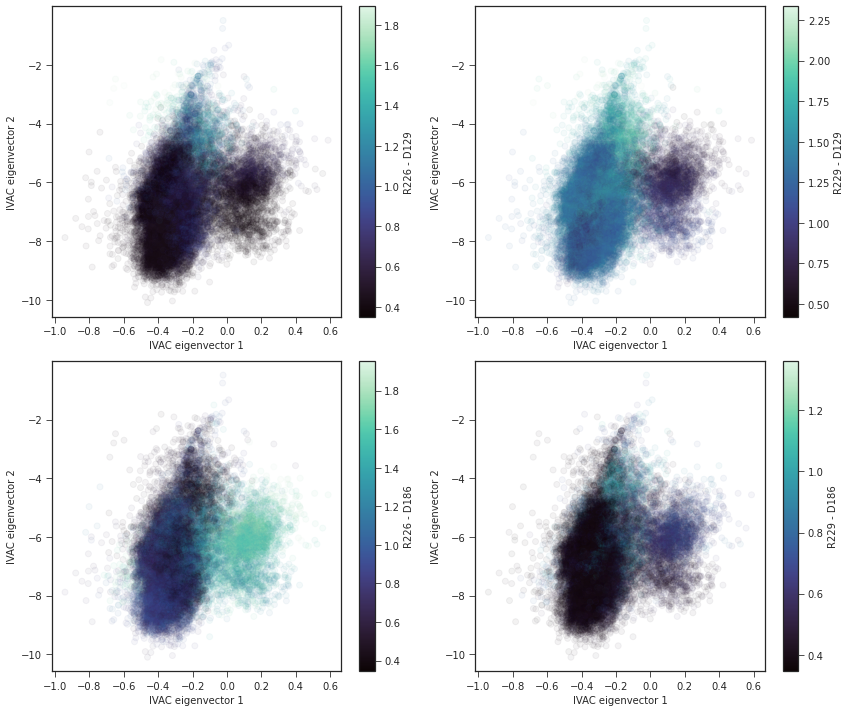

In [29]:
# project onto IVAC eigenvectors
f, axes = plt.subplots(2, 2, figsize=(12, 10))

start = 3000000
end = len(ivac_arr)
for i, (ax, j) in enumerate(zip(axes.flat, sb_ids)):
    h = ax.scatter(
        ivac_arr[start:end:s, 1],
        ivac_arr[start:end:s, 2],
        c=sb_arr[start:end:s, j],
        alpha=0.05,
        cmap="mako",
    )
    cbar = plt.colorbar(h, ax=ax, label=sb_labels[j - 30])
    cbar.solids.set(alpha=1)
    ax.set(xlabel="IVAC eigenvector 1", ylabel="IVAC eigenvector 2")

f.tight_layout()

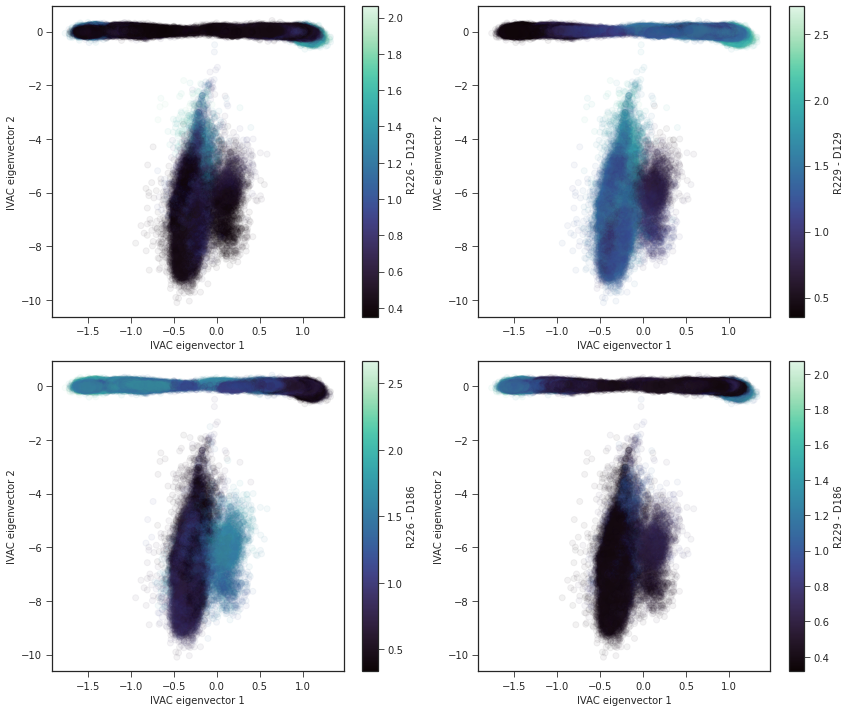

In [30]:
# project onto IVAC eigenvectors
f, axes = plt.subplots(2, 2, figsize=(12, 10))

start = 0
end = len(ivac_arr)
for i, (ax, j) in enumerate(zip(axes.flat, sb_ids)):
    h = ax.scatter(
        ivac_arr[start:end:s, 1],
        ivac_arr[start:end:s, 2],
        c=sb_arr[start:end:s, j],
        alpha=0.05,
        cmap="mako",
    )
    cbar = plt.colorbar(h, ax=ax, label=sb_labels[j - 30])
    cbar.solids.set(alpha=1)
    ax.set(xlabel="IVAC eigenvector 1", ylabel="IVAC eigenvector 2")

f.tight_layout()

## What if we do IVAC just on the new data?

In [31]:
with np.load("../../data/raw_feat/feat5_suppl_00.npz") as f:
    suppl_feat5 = f["arr_0"]

In [32]:
print(len(suppl_feat5), suppl_feat5[0].shape)

144 (3000, 1924)


In [35]:
livac = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=10, addones=False, reweight=True, adjust=True
)
livac.fit(suppl_feat5)
sup_ivac_trajs = livac.transform(suppl_feat5)
sup_ivac_arr = np.concatenate(sup_ivac_trajs)
print(sup_ivac_arr.shape)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ivac/utils.py:385: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


ValueError: array must not contain infs or NaNs

In [ ]:
plt.scatter(*sup_ivac_arr[:, 1:3].T, alpha=0.05)

## Try TICA instead of IVAC

In [17]:
tica = pyemma.coordinates.tica(data=feat5_trajs, lag=10, dim=10, chunksize=128)
projected_data = tica.get_output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'Implied timescales ($\\mu$s)')

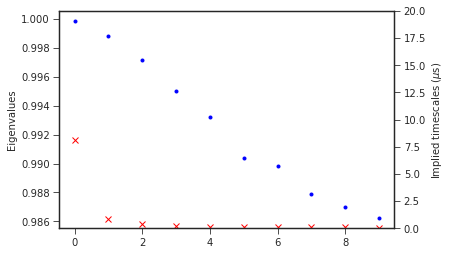

In [21]:
# do some plotting
plt.plot(tica.eigenvalues[:10], ".", color="blue")
plt.ylabel("Eigenvalues")
plt.twinx()
plt.plot(tica.timescales[:10] * 0.0001, "x", color="red")
plt.ylim([0, 20])
plt.ylabel("Implied timescales ($\mu$s)")

In [28]:
tica.fit_transform(feat5_trajs)

[array([[-0.41334578,  1.538062  ,  1.4427265 , ..., -0.05872481,
         -0.14110494, -0.07288306],
        [-0.3976257 ,  1.4838119 ,  1.4019564 , ...,  0.16551514,
         -0.15090637, -0.10514574],
        [-0.40623835,  1.5007018 ,  1.359091  , ..., -0.10337382,
         -0.1282628 , -0.27915493],
        ...,
        [-0.3900168 ,  1.1128107 ,  0.34153104, ...,  0.8471719 ,
         -0.07802336,  1.1300095 ],
        [-0.39577886,  1.084062  ,  0.3048019 , ...,  0.84473246,
         -0.1361348 ,  1.1129422 ],
        [-0.40264237,  1.069729  ,  0.26314253, ...,  0.7598133 ,
         -0.00655182,  1.1210579 ]], dtype=float32),
 array([[-0.3693433 ,  1.5652317 ,  1.3634516 , ..., -0.27612862,
         -0.12903076, -0.24340276],
        [-0.35349634,  1.5389203 ,  1.371761  , ..., -0.35201368,
         -0.11398871, -0.23455405],
        [-0.34634104,  1.5373003 ,  1.2922378 , ..., -0.5145722 ,
         -0.08322711, -0.19523998],
        ...,
        [-0.37562767,  1.277509  ,  0.6

In [36]:
projected_data = tica.get_output()

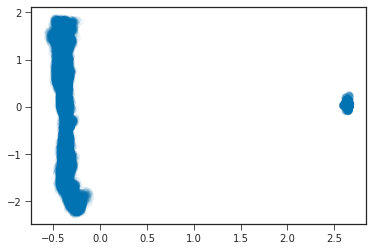

In [37]:
projected_arr = np.concatenate(projected_data)
end = len(projected_arr)
plt.scatter(projected_arr[:end:10, 0], projected_arr[:end:10, 1], alpha=0.05)

### Transformed distances

In [137]:
feat6_trajs = [np.exp(-traj) for traj in feat5_trajs]
feat6_livac = ivac.LinearIVAC(
    minlag=1, maxlag=10000, nevecs=10, addones=False, adjust=True
)
feat6_livac.fit(feat6_trajs)
ivac_trajs_6 = livac.transform(feat6_trajs)
ivac_arr_6 = np.concatenate(ivac_trajs_6)
print(ivac_arr_6.shape)

(3432000, 10)


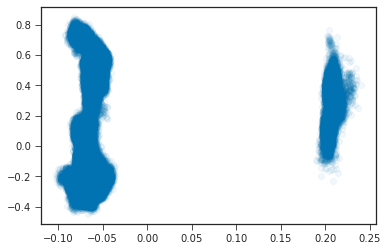

In [138]:
plt.scatter(ivac_arr_6[:end:10, 0], ivac_arr_6[:end:10, 1], alpha=0.05)

### Projections onto TICA

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
h0 = ax0.scatter(
    projected_arr[:end:10, 0],
    projected_arr[:end:10, 1],
    c=cv_arr[::10, 0],
    alpha=0.05,
    cmap="mako",
)
cbar = plt.colorbar(h0, ax=ax0)
cbar.solids.set(alpha=1)
h1 = ax1.scatter(
    projected_arr[::10, 0],
    projected_arr[::10, 1],
    c=cv_arr[::10, 1],
    alpha=0.05,
    cmap="mako",
)
cbar2 = plt.colorbar(h1, ax=ax1)
cbar2.solids.set(alpha=1)
f.tight_layout()

## Try with salt bridges

In [39]:
livac = ivac.LinearIVAC(minlag=1, maxlag=3000, nevecs=10, addones=False, adjust=True)
livac.fit(sb_trajs)
ivac_sb_trajs = livac.transform(sb_trajs)
ivac_sb_arr = np.concatenate(ivac_sb_trajs)
print(ivac_sb_arr.shape)

(3432000, 10)


In [94]:
import pickle

with open("../../data/livac-feat2-suppl.pkl", mode="wb+") as f:
    pickle.dump(livac, f)

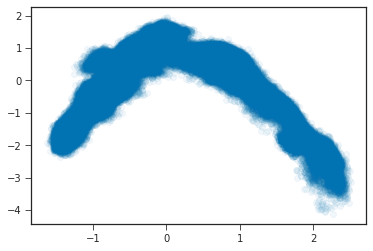

In [41]:
end = len(ivac_sb_arr)
plt.scatter(ivac_sb_arr[:end:10, 1], ivac_sb_arr[:end:10, 2], alpha=0.05)

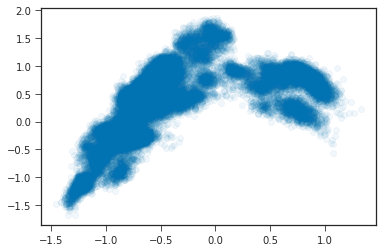

In [42]:
start = 3000000
end = len(ivac_sb_arr)
plt.scatter(ivac_sb_arr[start:end:10, 1], ivac_sb_arr[start:end:10, 2], alpha=0.05)

## Clustering with k-means

In [43]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=ivac_sb_arr, k=1000, max_iter=500, n_jobs=40
)

30-08-21 13:59:12 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[4] INFO     Cluster centers converged after 10 steps.


In [44]:
dtrajs = km.dtrajs[0]

In [45]:
np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl", dtrajs)

In [46]:
dtrajs.shape

(3432000,)

In [47]:
import importlib

importlib.reload(util)

<module 'util' from '../../python/util.py'>

# States

In [54]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
).nonzero()[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
).nonzero()[0]

In [56]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
# down = sb_arr[down_ids]
# up = sb_arr[up_ids]
# other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [59]:
assert (len(down_ids) + len(up_ids) + len(other_sbs)) == len(cv_arr)
print(f"Number of down structures:  {len(down_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
print(f"Number of other structures: {len(other_sbs)}")

Number of down structures:  33430
Number of up structures:   6649
Number of other structures: 3391921


## states

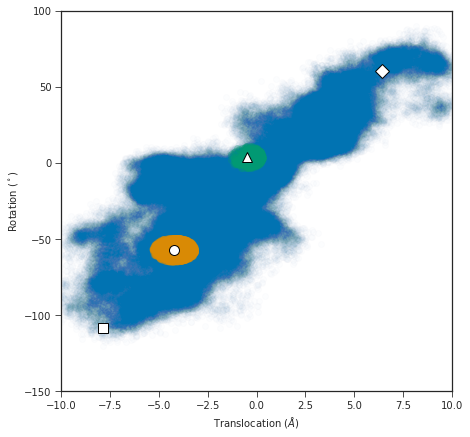

In [61]:
f = plt.figure(figsize=(7, 7))
ax = f.add_subplot(111)
s = 10
ax.scatter(cv_arr[::s, 0], cv_arr[::s, 1], alpha=0.01)
ax.scatter(down_cvs[::s, 0], down_cvs[::s, 1], alpha=0.2)
ax.scatter(up_cvs[::s, 0], up_cvs[::s, 1], alpha=0.2)
plotting.format_cvs(ax, centroids=True)

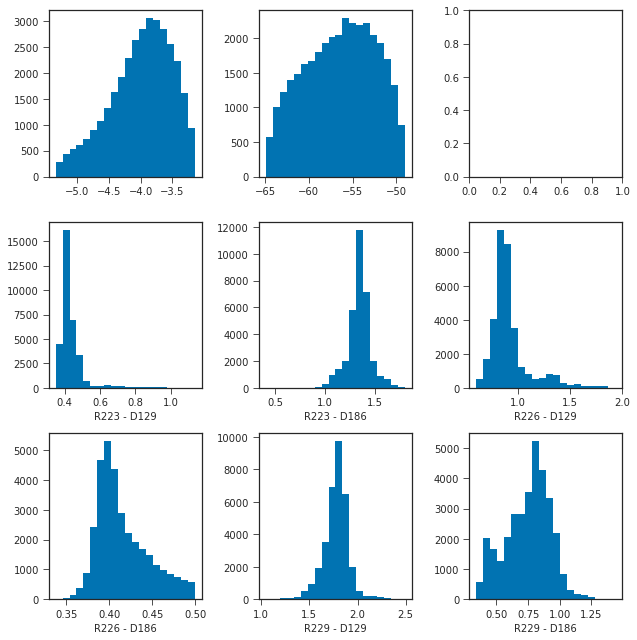

In [62]:
# histograms of CVs
f, axs = plt.subplots(3, 3, figsize=(9, 9))
axs[0][0].hist(down_cvs[:, 0], bins=20)
axs[0][1].hist(down_cvs[:, 1], bins=20)
# axs[0][2].hist(down_livac[:, 1], bins=20)
for i, (idx, ax) in enumerate(zip((36, 41, 42, 47, 48, 53), axs.flat[3:])):
    ax.hist(down_sbs[:, idx], bins=20)
    ax.set_xlabel(f"{sb_labels[idx - 30]}")
f.tight_layout()

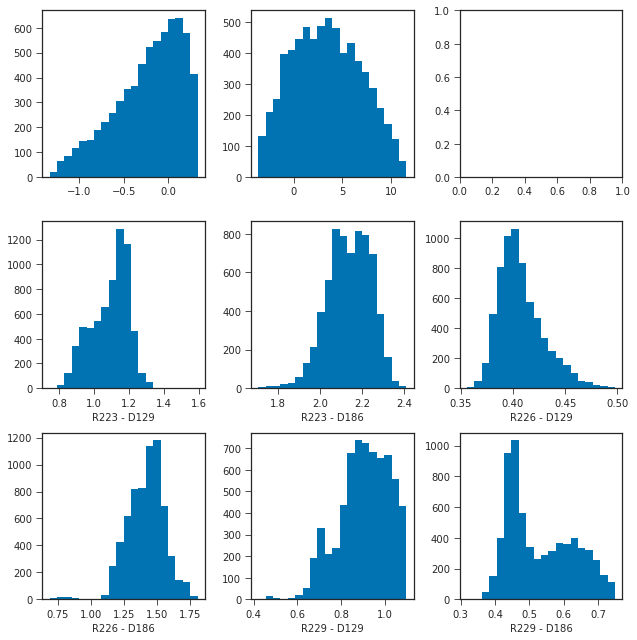

In [63]:
# histograms of CVs
f, axs = plt.subplots(3, 3, figsize=(9, 9))
axs[0][0].hist(up_cvs[:, 0], bins=20)
axs[0][1].hist(up_cvs[:, 1], bins=20)
# axs[0][2].hist(down_livac[:, 1], bins=20)
for i, (idx, ax) in enumerate(zip((36, 41, 42, 47, 48, 53), axs.flat[3:])):
    ax.hist(up_sbs[:, idx], bins=20)
    ax.set_xlabel(f"{sb_labels[idx - 30]}")
f.tight_layout()

# Basis and change of measure calculations

In [48]:
basisL_arr = util.make_sparse_basis(dtrajs)

In [50]:
basisL_arr.shape

(3432000, 1000)

In [64]:
# enforce boundary conditions for committor calculations
basisF_arr = basisL_arr
basisF_arr[down_ids] = 0
basisF_arr[up_ids] = 0

# remove basis functions which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr.A, axis=0) > 0)[0]
basisF_arr = basisF_arr[:, nonzero]
print(basisF_arr.shape)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(3432000, 1000)


In [65]:
traj_lens = [len(traj) for traj in cv_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

In [66]:
# split into lists of arrays
basisF, basisL = [], []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len

print(len(basisF), basisF[0].shape)
print(len(basisL), basisL[0].shape)

# guess functions
guess_down = np.zeros(len(cv_arr))
guess_down[down_ids] = 1
guessD = np.split(guess_down, traj_inds)
guess_up = np.zeros(len(cv_arr))
guess_up[up_ids] = 1
guessU = np.split(guess_up, traj_inds)
print(len(guessD), guessD[0].shape)
print(len(guessU), guessU[0].shape)

381 (10000, 1000)
381 (10000, 1000)
381 (10000,)
381 (10000,)


In [67]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

In [68]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight_sparse(basisL, lag))

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [69]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [70]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


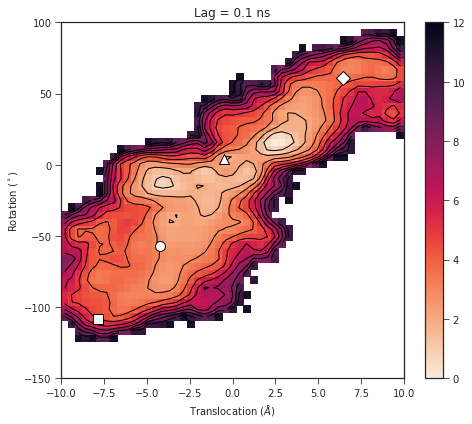

In [74]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(7, 6))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap="rocket_r", vmax=12, label="kT")
plt.colorbar(h, ax=ax)
ax.contour(
    centerx,
    centery,
    diff,
    levels=clines,
    colors="black",
    linestyles="solid",
    linewidths=1,
)
ax.set_title(f"Lag = 0.1 ns")
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [75]:
from itertools import combinations

In [76]:
sb_ids = [42, 48, 47, 53]

In [79]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 50)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 50)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[0], xlim, ylim)
    )

<IPython.core.display.Javascript object>


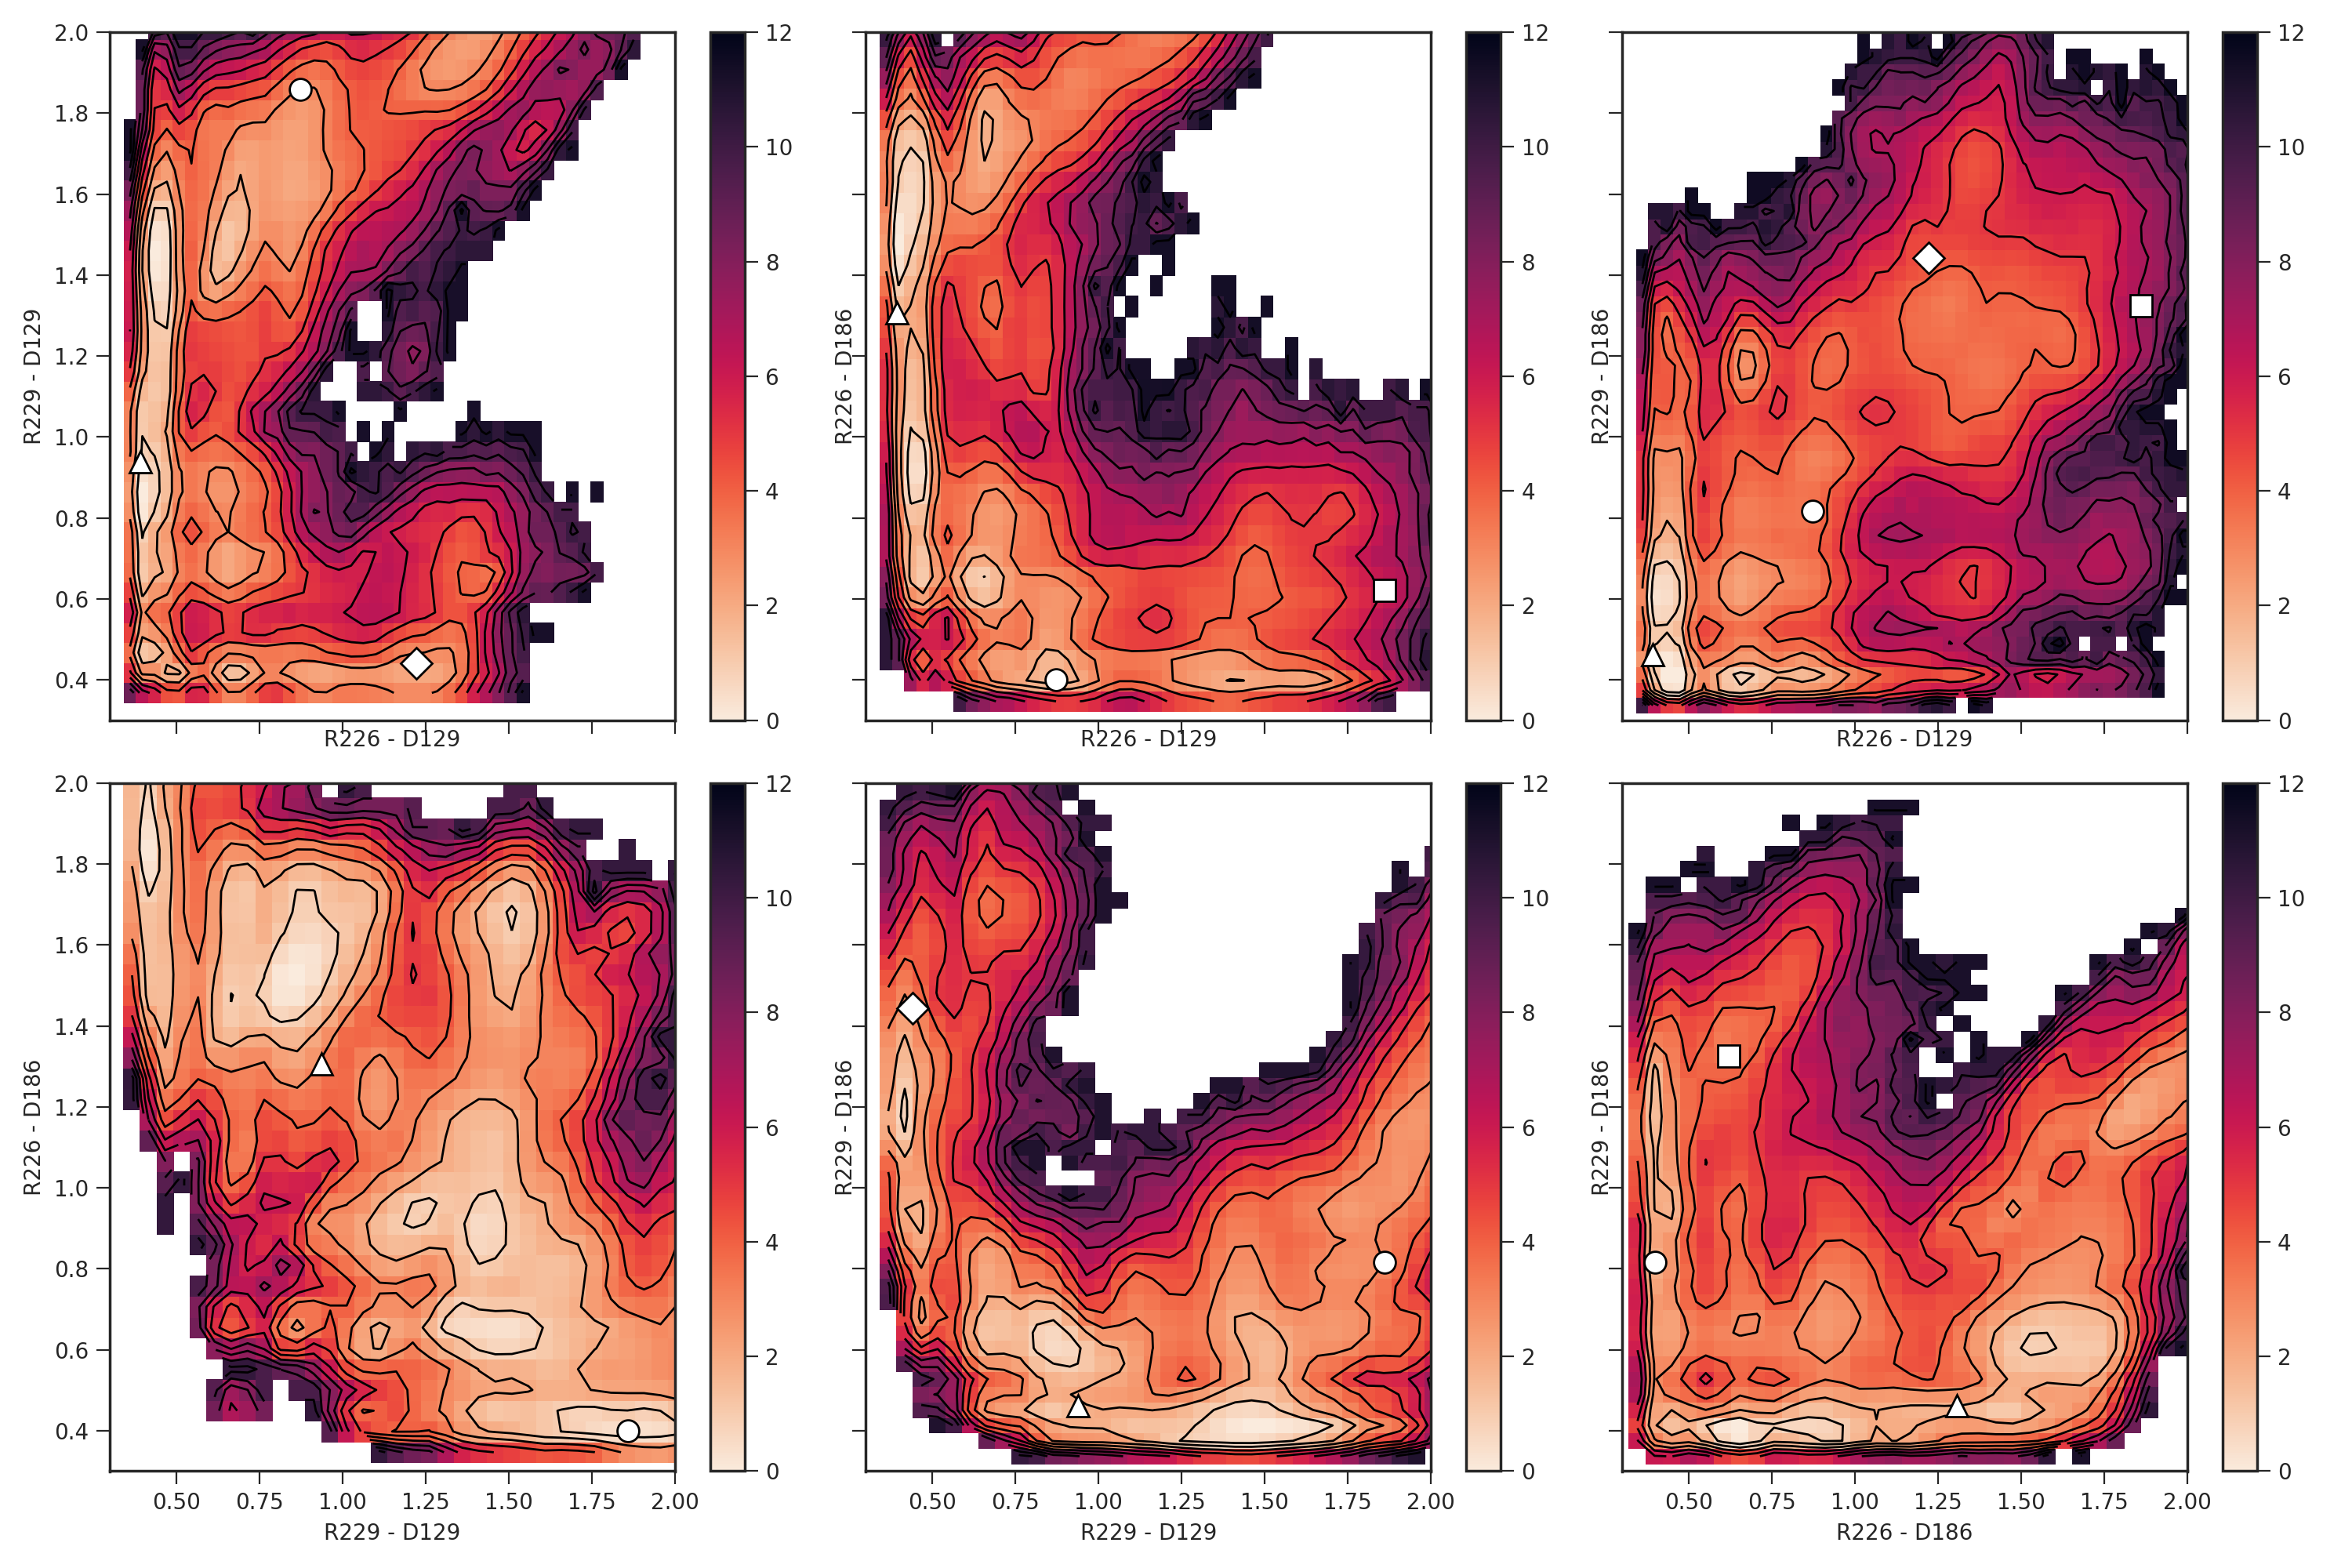

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [114]:
clines = np.linspace(0, 12, 13)
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for ((sb1, sb2), ax, pmf, xlim, ylim) in zip(
    combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
):
    # compute grid
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket_r", vmax=12, label="kT")
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
    ax.set_xlim([0.3, 2.0])
    ax.set_ylim([0.3, 2.0])
plotting.plot_sb_models(axes.flat, centroids=True)
f.tight_layout()

# Committors

In [83]:
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [84]:
len(in_domain)

381

In [85]:
q_downup = []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(
        extq.dga.forward_committor_sparse(basisF, com, in_domain, guessU, lag)
    )

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000
Calculating committors for lag 5000


AssertionError: 

In [86]:
np.save("../../data/feat2_ind1000_dd_suppl/q_downup.npy", q_downup[:-1])
np.save("../../data/feat2_ind1000_dd_suppl/com.npy", weights[:-1])

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


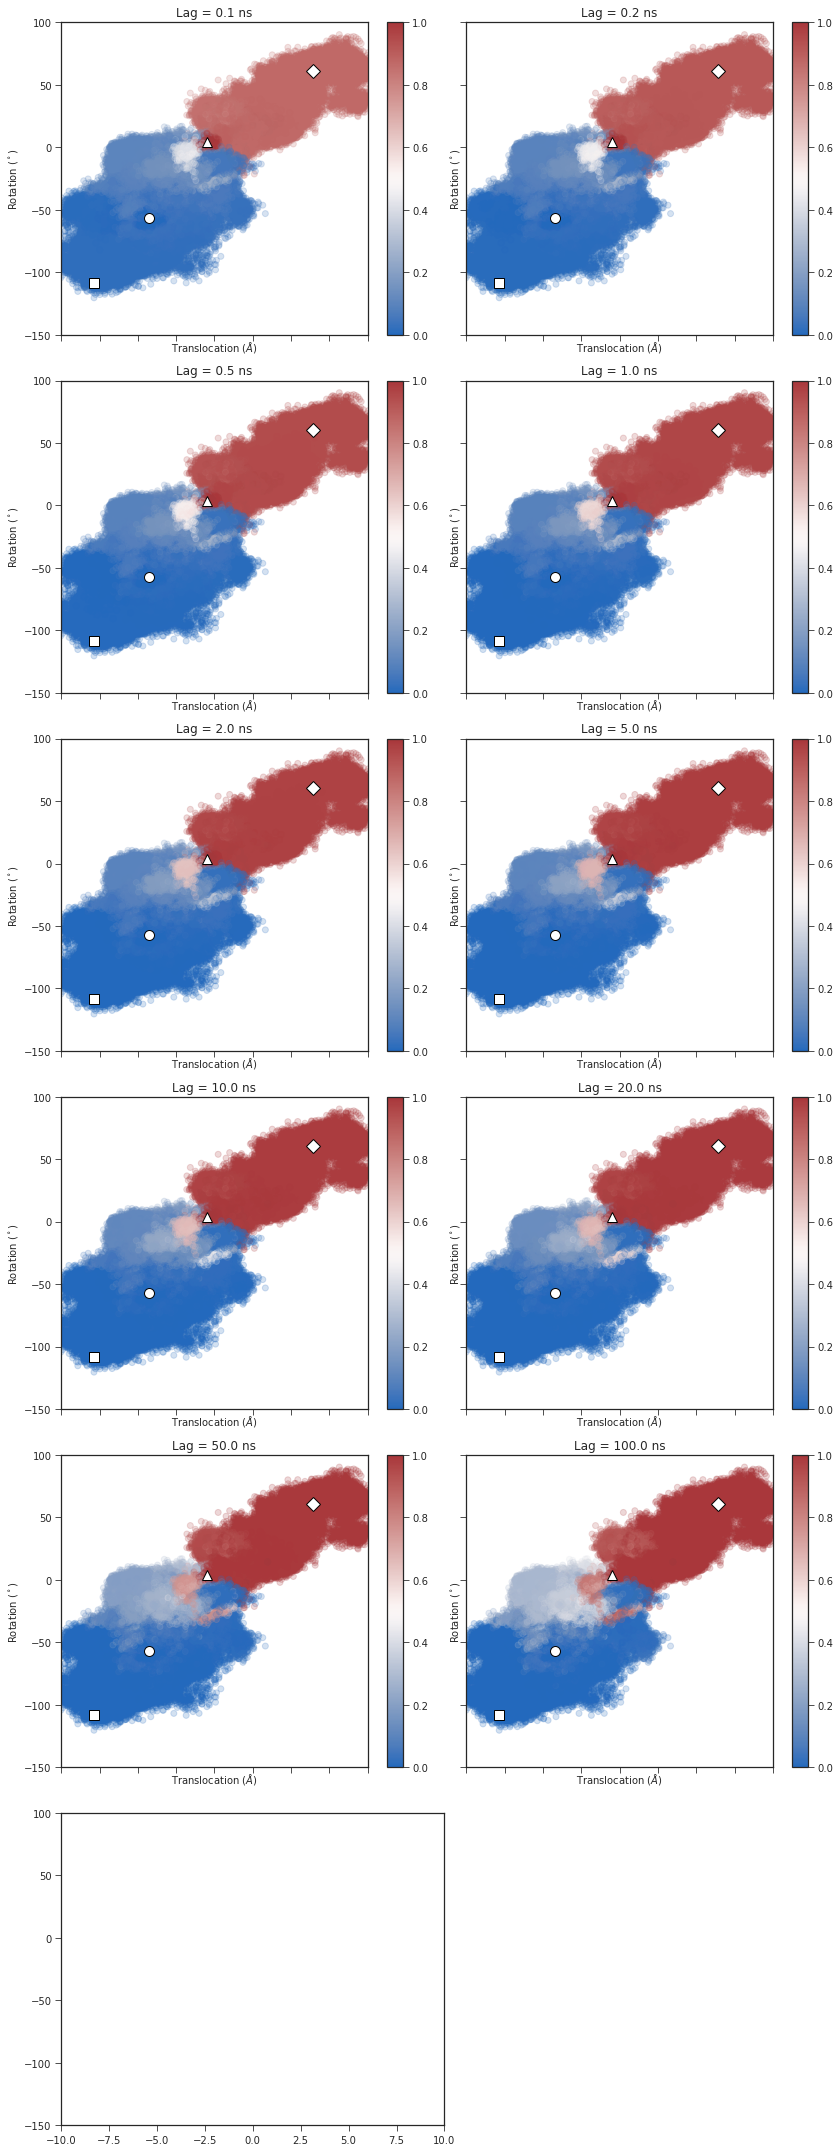

In [89]:
s = 10
f, axs = plt.subplots(6, 2, figsize=(12, 30), sharex=True, sharey=True)
for lag, q, ax in zip(lags[:-1], q_downup[:-1], axs.flat[:-1]):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*cv_arr[::s].T, c=q_arr[::s], cmap="vlag", alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True)
f.delaxes(axs[-1][-1])
f.tight_layout()

Text(0.5, 0.98, 'Committor, lag = 20.0 ns')

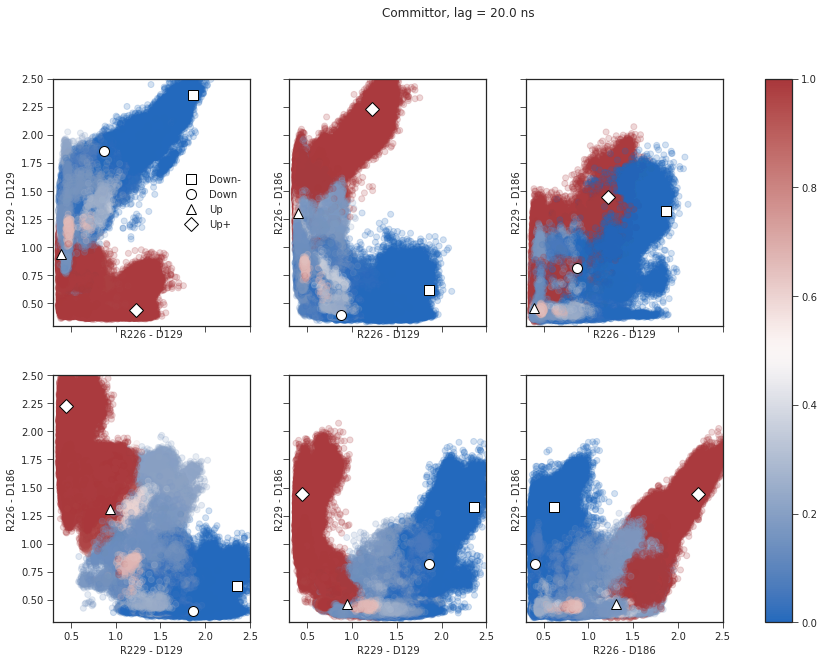

In [92]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

s = 10
q_arr = np.concatenate(q_downup[7])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        sb_arr[::s, sb1], sb_arr[::s, sb2], c=q_arr[::s], cmap="vlag", alpha=0.2
    )
    ax.set(
        xlabel=sb_labels[sb1 - 30],
        ylabel=sb_labels[sb2 - 30],
        xlim=[0.3, 2.5],
        ylim=[0.3, 2.5],
    )
cbar = f.colorbar(h, ax=axes.ravel().tolist())
cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")

plt.suptitle(f"Committor, lag = {lags[7] * 0.1} ns")
# f.tight_layout()

In [95]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

In [97]:
sb_models.shape

(4, 60)

In [98]:
ivac_models = livac.transform([sb_models])[0]

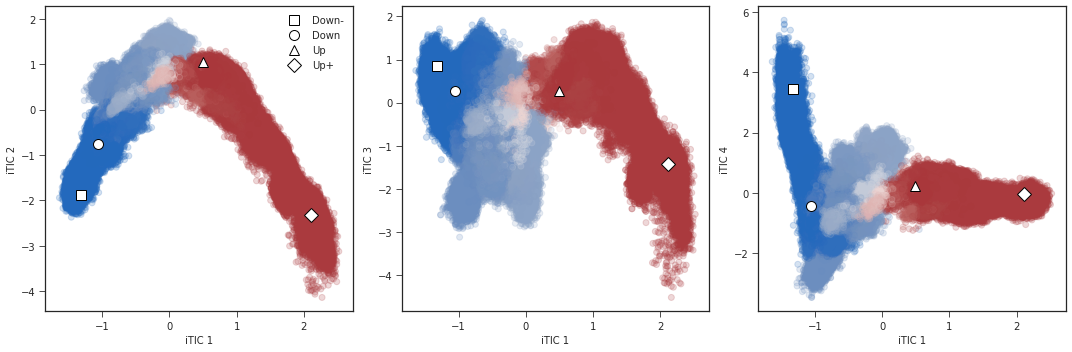

In [100]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
# q_arr = np.concatenate(q_downup[7]).clip(min=0., max=1.)
for i, ax in enumerate(axes):
    ax.scatter(
        ivac_sb_arr[::s, 1],
        ivac_sb_arr[::s, i + 2],
        c=q_arr[::s],
        cmap="vlag",
        alpha=0.2,
    )
    ax.set(xlabel=f"iTIC 1", ylabel=f"iTIC {i + 2}")
plotting.plot_models(axes[0], ivac_models[:, 1:3])
plotting.plot_models(axes[1], ivac_models[:, 1:4:2])
plotting.plot_models(axes[2], ivac_models[:, 1:5:3])
axes[0].legend(["Down-", "Down", "Up", "Up+"])

f.tight_layout()

In [101]:
com = np.concatenate(weights[7])
q_arr = np.concatenate(q_downup[7])
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=com
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Committor, lag = 20 ns')

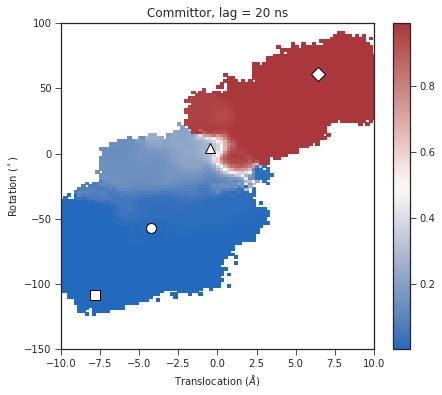

In [103]:
f, ax = plt.subplots(figsize=(7, 6))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap="vlag")
plt.colorbar(
    h,
    ax=ax,
)
plotting.format_cvs(ax, centroids=True)
plt.title("Committor, lag = 20 ns")

### 3d projections

In [104]:
%matplotlib notebook

In [105]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

<IPython.core.display.Javascript object>


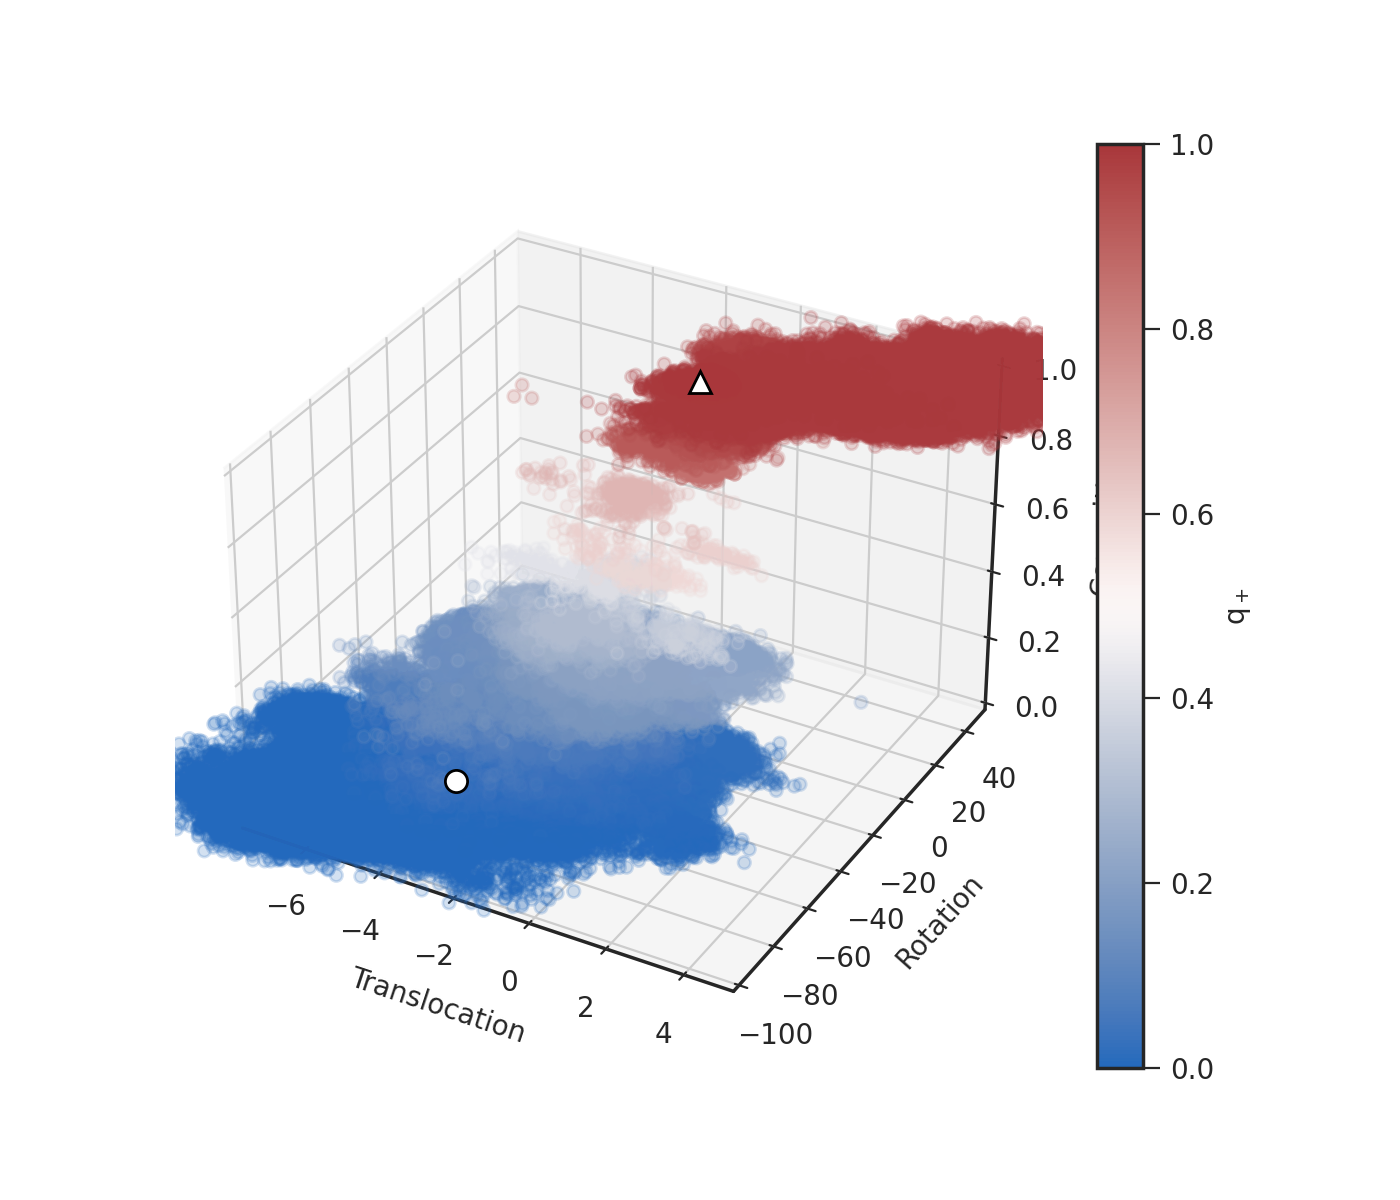

In [106]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
q = np.concatenate(q_downup[7]).clip(min=0, max=1)
h = ax.scatter(
    cv_arr[::s, 0], cv_arr[::s, 1], q[::s], c=q[::10], cmap="vlag", alpha=0.2
)
ax.set_xlabel("Translocation")
ax.set_ylabel("Rotation")
ax.set_zlabel("Committor")
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])

cbar = plt.colorbar(h, ax=ax, label="q$_+$")
cbar.solids.set(alpha=1.0)

ax.plot(centroids[1, 0], centroids[1, 1], 0, "o", mec="k", mfc="w", ms=8)
ax.plot(centroids[2, 0], centroids[2, 1], 1, "^", mec="k", mfc="w", ms=8)

In [108]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

<IPython.core.display.Javascript object>


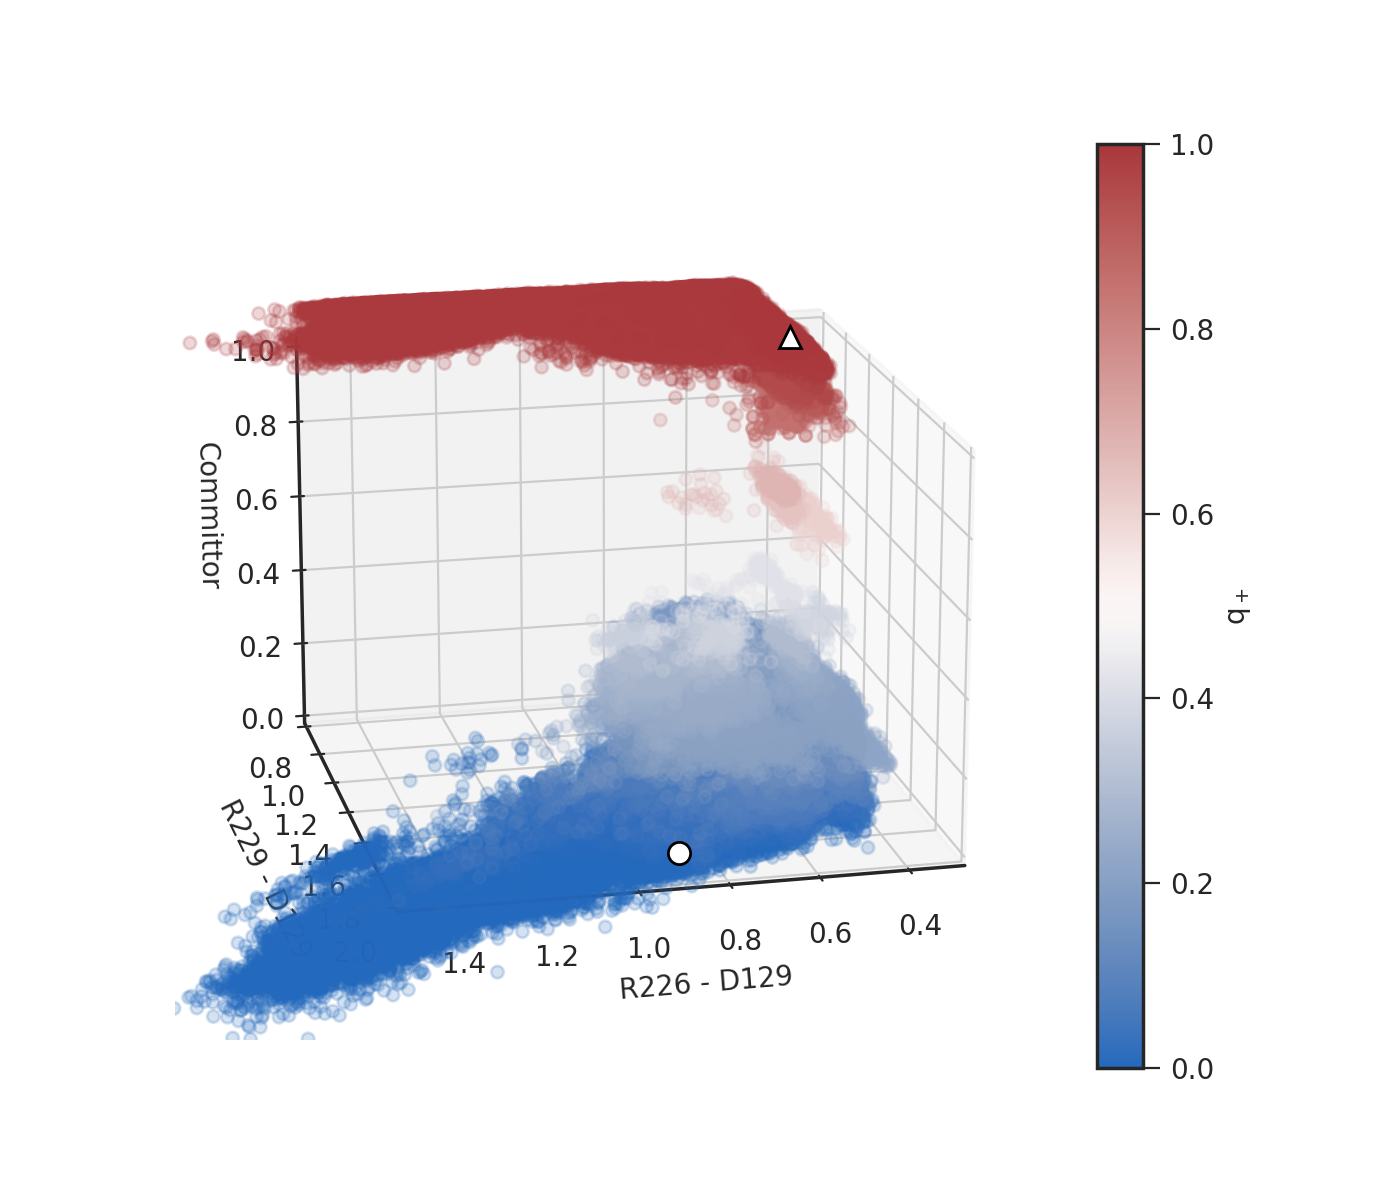

In [110]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

s = 10
ax.scatter(
    sb_arr[::s, sb_ids[0]],
    sb_arr[::s, sb_ids[1]],
    q[::s],
    c=q[::10],
    cmap="vlag",
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]}")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]}")
ax.set_zlabel("Committor")
ax.set_xlim([0.3, 1.5])
ax.set_ylim([0.8, 2.0])
ax.set_zlim([0, 1.0])
ax.view_init(elev=25, azim=30)

cbar = plt.colorbar(h, ax=ax, label="q$_+$")
cbar.solids.set(alpha=1.0)

ax.plot(
    feat2_models[1, sb_ids[0]],
    feat2_models[1, sb_ids[1]],
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
)
ax.plot(
    feat2_models[2, sb_ids[0]],
    feat2_models[2, sb_ids[1]],
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
)